In [1]:
from mylib.statistic_test import *

code_id = "0874 - Detailed Dynamical Analysis"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

dir_name = r'D:\Data\FinalResults\Dsp\Reforming Neural Trajectory Analysis'

pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0874 - Detailed Dynamical Analysis is already existed!


100%|██████████| 1349/1349 [00:00<00:00, 16050.62it/s]


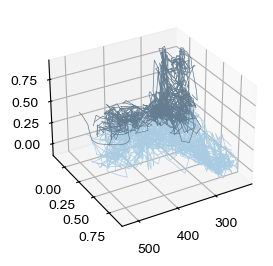

In [ ]:
def get_intersected(route: int, maze_type: int):
    return np.intersect1d(CP_DSPs[maze_type][route], CP_DSPs[maze_type][0])

def get_cell_indexes(mouse: int, session: int):
    assert session < 7 and isinstance(session, int)
    idx = np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
    
    with open(f_CellReg_dsp['cellreg_folder'][idx], 'rb') as f:
        index_map = pickle.load(f).astype(np.int64)
        
    if mouse in [10212, 10224, 10227]:
        index_map = index_map[1:, :]
    
    is_cell = np.where(index_map > 0, 1, 0)
    idx = np.where(np.sum(is_cell, axis=0) == 7)[0]
    return index_map[session, idx] - 1

def get_r0_map(trace: dict, route: int, session: int):
    assert route != 0, "Route 0 is not supported."
    if trace['maze_type'] in [1, 2]:
        if route in [1, 2, 3]:
            included_nodes = [0, 4]
        else:
            included_nodes = [5, 9]
    elif trace['maze_type'] == 4:
        if route in [1, 2, 3, 7]:
            included_nodes = [0, 5]
        else:
            included_nodes = [6, 10]
    else:
        raise ValueError(f"Unsupported maze type. Got {trace['maze_type']}")
    
    mean_map = np.mean(np.stack([trace[f'node {n}']['smooth_map_all'] for n in included_nodes], axis=2), axis=2)
    return mean_map[get_cell_indexes(trace['MiceID'], session), :]

def get_mean_map(trace: dict, route: int, session: int):
    assert route != 0, "Route 0 is not supported."
    convertor1 = np.array([0, 1, 2, 3, 6, 7, 8])
    convertor1m = np.array([0, 1, 2, 3, 7, 8, 9, 4])
    if trace['maze_type'] in [1, 2]:
        included_nodes = convertor1[route]
    elif trace['maze_type'] == 4:
        included_nodes = convertor1m[route]
        
    return trace[f'node {included_nodes}']['smooth_map_all'][get_cell_indexes(trace['MiceID'], session), :]

def identify_part(route: int, maze_type: int):
    assert route != 0, "Route 0 is not supported."
    if maze_type in [1, 2]:
        if route in [1, 2, 3]:
            return 0
        else:
            return 1



R = 5
S = 6
M = 10224
with open(join(dir_name, f'{M}.pkl'), 'rb') as f:
    res = pickle.load(f)
    
with open(f2['Trace File'][np.where(f2['MiceID'] == M)[0][S]], 'rb') as f:
    trace = pickle.load(f)
    
D = GetDMatrices(maze_type=trace['maze_type'], nx=48)
neural_traj = res['neural_traj']
time_traj = res['time_traj']
nodes_traj = res['pos_traj']
session_traj = res['session_traj']
route_traj = res['route_traj']
lap_traj = res['lap_traj']

beg, end = LapSplit(trace, behavior_paradigm='CrossMaze')
first_SB_lap = np.where(trace['correct_time'][end] >= trace['node 5']['ms_time_behav'][0])[0][0]

idx_R = np.where((session_traj == S) & (route_traj == R) & np.isin(S2F[nodes_traj], get_intersected(R, trace['maze_type'])))[0]
if identify_part(R, trace['maze_type']) == 0:
    idx_R0 = np.where(
        (session_traj == S) & 
        (route_traj == 0) & 
        (lap_traj < first_SB_lap) & 
        np.isin(S2F[nodes_traj], get_intersected(R, trace['maze_type']))
    )[0]
else:
    idx_R0 = np.where(
        (session_traj == S) & 
        (route_traj == 0) & 
        (lap_traj >= first_SB_lap) & 
        np.isin(S2F[nodes_traj], get_intersected(R, trace['maze_type']))
    )[0]

mean_map_r0 = get_r0_map(trace, R, session=S)
mean_map_r = get_mean_map(trace, R, session=S)
corr_traj_R = np.zeros((idx_R.shape[0], 2), dtype=np.float64)
corr_traj_R0 = np.zeros((idx_R0.shape[0], 2), dtype=np.float64)

assert mean_map_r0.shape[0] == neural_traj.shape[0]

for i in tqdm(range(len(corr_traj_R0))):
    corr_traj_R0[i, 0] = np.corrcoef(neural_traj[:, idx_R0[i]], mean_map_r0[:, nodes_traj[idx_R0[i]]])[0, 1]
    corr_traj_R0[i, 1] = np.corrcoef(neural_traj[:, idx_R0[i]], mean_map_r[:, nodes_traj[idx_R0[i]]])[0, 1]

for i in tqdm(range(len(corr_traj_R))):
    corr_traj_R[i, 0] = np.corrcoef(neural_traj[:, idx_R[i]], mean_map_r0[:, nodes_traj[idx_R[i]]])[0, 1]
    corr_traj_R[i, 1] = np.corrcoef(neural_traj[:, idx_R[i]], mean_map_r[:, nodes_traj[idx_R[i]]])[0, 1]

dlap_R0 = np.concatenate(([0], np.where(np.diff(lap_traj[idx_R0]) != 0)[0]+1, [len(idx_R0)]))

fig = plt.figure(figsize=(6, 3))
ax = Clear_Axes(fig.add_subplot(111, projection='3d'), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(len(dlap_R0)-1):
    ax.plot(
        D[nodes_traj[idx_R0][dlap_R0[i]:dlap_R0[i+1]], 0], 
        corr_traj_R0[dlap_R0[i]:dlap_R0[i+1], 0],
        corr_traj_R0[dlap_R0[i]:dlap_R0[i+1], 1],
        color=DSPPalette[0],
        linewidth=0.5
    )
dlap_R = np.concatenate(([0], np.where(np.diff(lap_traj[idx_R]) != 0)[0]+1, [len(idx_R)]))
for i in range(len(dlap_R)-1):
    ax.plot(
        D[nodes_traj[idx_R][dlap_R[i]:dlap_R[i+1]], 0], 
        corr_traj_R[dlap_R[i]:dlap_R[i+1], 0], 
        corr_traj_R[dlap_R[i]:dlap_R[i+1], 1],
        color=DSPPalette[R],
        linewidth=0.5
    )
ax.view_init(elev=10, azim=60)